In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import load_model
import os

from keras.optimizers import Adam

from fully_conv_model_for_lidar import fcn_model
from util_func import *
from train import *

from keras.utils.generic_utils import get_custom_objects
#loss = SSD_Loss(neg_pos_ratio=neg_pos_ratio, alpha=alpha)
get_custom_objects().update({"my_loss": my_loss})

#import keras.losses
#keras.losses.custom_loss = my_loss

Using TensorFlow backend.


In [2]:
model = load_model('saved_model/model_with_augmentation.h5')

[<tf.Tensor 'gradients/split_1_grad/concat:0' shape=(?, 64, 256, 8) dtype=float32>, None, None]


In [3]:
lidar = np.load('./extract_kiti/0005/lidar/lidar_0.npy')
gt_box = np.load('./extract_kiti/0005/gt_boxes3d/gt_boxes3d_0.npy')
#view, box = cylindrical_projection_for_training(lidar, gt_box)
#print(view.shape, box.shape)

In [4]:
# offset_range = 5*np.pi/180
# flip = 1
# offset = np.random.uniform(low=-offset_range, high=offset_range)
# lidar, gt_box = augmentation(offset, flip, lidar, gt_box)

In [5]:
flip = 1
offset = 0
lidar, gt_box = augmentation(offset, flip, lidar, gt_box)

In [6]:
viz_mayavi_with_labels(lidar, gt_box)

In [7]:
view, box = cylindrical_projection_for_training(lidar, gt_box)
#new_view, new_box = cylindrical_projection_for_training(new_lidar, new_gt_box)
#print(view.shape, box.shape)

In [8]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# fig, ax = plt.subplots(2,1, figsize = (25,15))
# ax[0].imshow(view[:,:,0])
# ax[1].imshow(new_view[:,:,0])

In [9]:
view = view.reshape(1,64,256,2)
pred = model.predict(view)
print(pred.shape)

(1, 64, 256, 8)


In [10]:
label_view = cylindrical_projection_for_test(lidar)
print(label_view.shape)

(64, 256, 5)


In [11]:
pred_view = pred[0]


In [12]:
boxes = np.zeros((64,256,8,3))
for i in range(64):
    for j in range(256):
        boxes[i,j,0] = label_view[i,j,:3] - rotation(label_view[i,j,3],pred_view[i,j,1:4])
        boxes[i,j,6] = label_view[i,j,:3] - rotation(label_view[i,j,3],pred_view[i,j,4:7])
        boxes[i,j,2,:2] = boxes[i,j,6,:2]
        boxes[i,j,2,2] = boxes[i,j,0,2]
        
        phi = pred_view[i,j,-1]
        z = boxes[i,j,2] - boxes[i,j,0]
        boxes[i,j,1,0] = (np.cos(phi)*z[0] + np.sin(phi)*z[1])*np.cos(phi) + boxes[i,j,0,0]
        boxes[i,j,1,1] = (-np.sin(phi)*z[0] + np.cos(phi)*z[1])*np.cos(phi) + boxes[i,j,0,1]
        boxes[i,j,1,2] = boxes[i,j,0,2]
        
        boxes[i,j,3] = boxes[i,j,0] + boxes[i,j,2] - boxes[i,j,1]
        boxes[i,j,4] = boxes[i,j,0] + boxes[i,j,6] - boxes[i,j,2]
        boxes[i,j,5] = boxes[i,j,1] + boxes[i,j,4] - boxes[i,j,0]
        boxes[i,j,7] = boxes[i,j,4] + boxes[i,j,6] - boxes[i,j,5]


In [13]:
pred_boxes = boxes[pred_view[:,:,0]>0.5].reshape(-1,8,3)
print(pred_boxes.shape)

(1067, 8, 3)


In [14]:
#viz_mayavi_with_labels(lidar, pred_boxes[[1,100,200,500,1000]])

In [15]:
viz_mayavi_with_labels(lidar, pred_boxes[100:120])

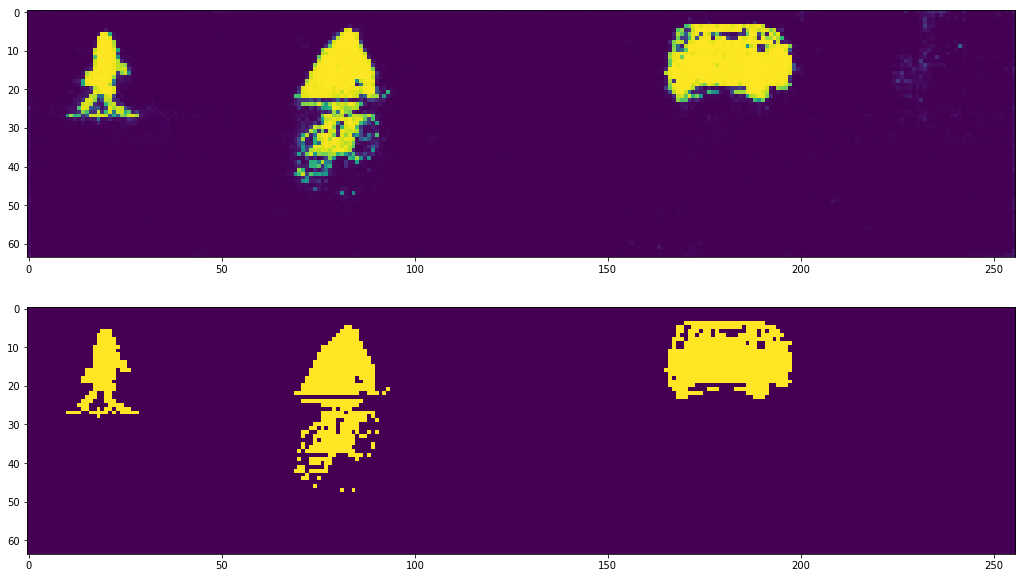

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,1, figsize=(24,10))
ax[0].imshow(pred_view[:,:,0])
    #ax[1].imshow(pred_view[:,:,1])
ax[1].imshow(box[:,:,0])
#ax[3].imshow(view[0,:,:,1])

## Clustering predicted boxes

In [17]:
print(pred_view.shape)
print(label_view.shape)

(64, 256, 8)
(64, 256, 5)


In [18]:
boxes = pred_view.reshape(-1,8)
labels = label_view.reshape(-1,5)
thres_boxes = boxes[boxes[:,0] > 0.5 ]
thres_labels = labels[boxes[:,0] > 0.5 ]

In [19]:
print(thres_boxes.shape)
print(thres_labels.shape)

(1067, 8)
(1067, 5)


In [20]:
num_boxes = len(thres_boxes)
box_dist = np.zeros((num_boxes, num_boxes))

In [21]:
centers = np.zeros((num_boxes,3))
for i in range(num_boxes):
    p0 = thres_labels[i,:3] - rotation(thres_labels[i,3],thres_boxes[i,1:4])
    p6 = thres_labels[i,:3] - rotation(thres_labels[i,3],thres_boxes[i,4:7])
    
    centers[i] = (p0+p6)/2

In [22]:
for i in range(num_boxes):
    box_dist[i] = np.sqrt(np.sum(np.square(centers[[i]] - centers), axis = 1)) 

In [23]:
dist_thres = 0.1
neigbor_thres = 5
min_dist = 2

thres_box_dist = box_dist < dist_thres
neighbor = np.sum(thres_box_dist, axis = 1)

list_boxes = []
list_labels = []
while len(neighbor)>0:
    print('------------')
    ind = np.argmax(neighbor)
    print(ind)
    if neighbor[ind] < neigbor_thres:
        break
    
    list_boxes.append(thres_boxes[ind])
    list_labels.append(thres_labels[ind])
    
    remain_indx = box_dist[ind] > min_dist
    #print(remain_indx.shape, thres_box_dist.shape)
    
    box_dist = box_dist[remain_indx]
    box_dist = box_dist[:,remain_indx]
    
    thres_box_dist = thres_box_dist[remain_indx]
    thres_box_dist = thres_box_dist[:,remain_indx]
            
    thres_boxes = thres_boxes[remain_indx]
    thres_labels = thres_labels[remain_indx]
    
    print(box_dist.shape, thres_box_dist.shape, boxes.shape, labels.shape)
    
    
    neighbor = np.sum(thres_box_dist, axis = 1)
print(len(list_boxes))

------------
289
((648, 648), (648, 648), (16384, 8), (16384, 5))
------------
200
((156, 156), (156, 156), (16384, 8), (16384, 5))
------------
103
((2, 2), (2, 2), (16384, 8), (16384, 5))
------------
0
3


In [24]:
list_boxes = np.array(list_boxes)
list_labels = np.array(list_labels)
def cluster_boxes(list_boxes, list_labels):

    num_boxes = len(list_boxes)
    boxes = np.zeros((num_boxes,8,3))

    for i in range(len(list_boxes)):
        boxes[i,0] = list_labels[i,:3] - rotation(list_labels[i,3],list_boxes[i,1:4])
        boxes[i,6] = list_labels[i,:3] - rotation(list_labels[i,3],list_boxes[i,4:7])
        boxes[i,2,:2] = boxes[i,6,:2]
        boxes[i,2,2] = boxes[i,0,2]

        phi = list_boxes[i,-1]
        z = boxes[i,2] - boxes[i,0]
        boxes[i,1,0] = (np.cos(phi)*z[0] + np.sin(phi)*z[1])*np.cos(phi) + boxes[i,0,0]
        boxes[i,1,1] = (-np.sin(phi)*z[0] + np.cos(phi)*z[1])*np.cos(phi) + boxes[i,0,1]
        boxes[i,1,2] = boxes[i,0,2]

        boxes[i,3] = boxes[i,0] + boxes[i,2] - boxes[i,1]
        boxes[i,4] = boxes[i,0] + boxes[i,6] - boxes[i,2]
        boxes[i,5] = boxes[i,1] + boxes[i,4] - boxes[i,0]
        boxes[i,7] = boxes[i,4] + boxes[i,6] - boxes[i,5]
    return boxes

    
predict_boxes = cluster_boxes(list_boxes, list_labels)
print(predict_boxes.shape)

(3, 8, 3)


In [25]:
viz_mayavi_with_labels(lidar, predict_boxes)

In [26]:
np.random.randint(2)

0

### Continue training

data_dir = './extract_kiti/'

list_of_lidar, list_of_gtbox = list_of_data(data_dir)

# test on just one sample
list_of_lidar = [list_of_lidar[108]]
list_of_gtbox = [list_of_gtbox[108]]

model.fit_generator(generator=train_batch_generator(list_of_lidar, list_of_gtbox, batch_size = 1, data_augmentation = False),
                        epochs=500)
model.save("saved_model/model_test.h5")